Author: Madhusudhanan Balasubramanian, Ph.D.
        The University of Memphis

## AP statistics as a function of training models

* June 6, 2024: AP and AR statistics directly computed from coco_eval.eval['precision'] and coco_eval.eval['recall']
    Assuming that there are only two categories
* 3/31/2025: Finalizing results for manuscript/publication

In [ ]:
!wget https://raw.githubusercontent.com/cocodataset/cocoapi/master/PythonAPI/pycocotools/cocoeval.py

Prepare for analysis

In [2]:
import os
import glob
import re
import json
from centermask.config import get_cfg
from centermask.evaluation import COCOEvaluator, inference_on_dataset
from pycocotools.coco import COCO
#from pycocotools.cocoeval import COCOeval
#from centermask.evaluation import COCOeval
from centermask.evaluation.cocoeval import COCOeval
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.engine import DefaultTrainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def estimate_model_performance(precisions, recalls):
    """
    Estimates model performance (AP, AR) from precisions and recalls matrices.
    
    Args:
        precisions (np.ndarray): Precision values from COCOeval.
        recalls (np.ndarray): Recall values from COCOeval.
    
    Returns:
        dict: A dictionary containing AP50, AP50to95, AR50, and AR50to95 for overall and per-category.
    """

    model_perf_dict = {
        'AP@50': [np.mean(precisions[0, 0, :, 0, 2]), precisions[0, 0, 0, 0, 2], precisions[0, 0, 1, 0, 2]],
        'AP@50Area': [np.mean(precisions[0, 0, :, 1, 2]), np.mean(precisions[0, 0, :, 2, 2]), np.mean(precisions[0, 0, :, 3, 2])],
        "AP50": [np.mean(precisions[0, :, :, 0, 2]), np.mean(precisions[0, :, 0, 0, 2]), np.mean(precisions[0, :, 1, 0, 2])],
        "AP50Area": [np.mean(precisions[0, :, :, 1, 2]), np.mean(precisions[0, :, :, 2, 2]), np.mean(precisions[0, :, :, 3, 2])],
        "AP50To95": [np.mean(precisions[:, :, :, 0, 2]), np.mean(precisions[:, :, 0, 0, 2]), np.mean(precisions[:, :, 1, 0, 2])],
        "AP50To95Area": [np.mean(precisions[:, :, :, 1, 2]), np.mean(precisions[:, :, :, 2, 2]), np.mean(precisions[:, :, :, 3, 2])],
        "AR50": [np.mean(recalls[0, :, 0, 2]), np.mean(recalls[0, 0, 0, 2]), np.mean(recalls[0, 1, 0, 2])],
        "AR50Area": [np.mean(recalls[0, :, 1, 2]), np.mean(recalls[0, :, 2, 2]), np.mean(recalls[0, :, 3, 2])],
        "AR50To95": [np.mean(recalls[:, :, 0, 2]), np.mean(recalls[:, 0, 0, 2]), np.mean(recalls[:, 1, 0, 2])],
        "AR50To95Area": [np.mean(recalls[:, :, 1, 2]), np.mean(recalls[:, :, 2, 2]), np.mean(recalls[:, :, 3, 2])]
    }
    return model_perf_dict

def numerical_sort(value):
    """Key function for sorting filenames numerically."""
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def register_datasets(dataset_names):
    """Registers multiple COCO datasets with Detectron2 if not already registered.

    Args:
        dataset_names (list): List of dataset names to register.
    """
    for dataset_name in dataset_names:
        json_file = f"./datasets/{dataset_name}/{dataset_name}.json"
        image_root = f"./datasets/{dataset_name}"

        if dataset_name not in DatasetCatalog.list():
            try:
                register_coco_instances(dataset_name, {}, json_file, image_root)
                print(f"Registered dataset '{dataset_name}'")
            except FileNotFoundError:
                print(f"Warning: Could not find annotation file or image directory for '{dataset_name}'")
        else:
            print(f"Dataset '{dataset_name}' already registered, skipping.")

class Trainer(DefaultTrainer):
    """
    This is the same Trainer except that we rewrite the
    `build_train_loader` method.
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_list = []
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder, max_dets_per_image=600))
        return evaluator_list[0]
    
#Register training axon datasets
dataset_names= ["Phase3_Training", "Phase3_Validation", "Phase3_Testing", "Quigley_Eval"]
register_datasets(dataset_names)

Dataset 'Phase3_Training' already registered, skipping.
Dataset 'Phase3_Validation' already registered, skipping.
Dataset 'Phase3_Testing' already registered, skipping.
Dataset 'Quigley_Eval' already registered, skipping.


### Evaluate model on dataset_name

In [3]:
def eval_model_on_dataset_name(dataset_name, bbox_or_segm):
    metadata = MetadataCatalog.get(dataset_name)
    dicts = DatasetCatalog.get(dataset_name)

    gt_json_file = f"./datasets/{dataset_name}/{dataset_name}.json"

    # Load configuration (change this to your actual config file)
    cfg = get_cfg()
    cfg.merge_from_file("configs/AxonClass/axon_V_39_eSE_FPN_ms_3x.yaml")
    #cfg.INPUT.MIN_SIZE_TEST = 512

    # Get the model output directory
    output_dir = cfg.OUTPUT_DIR 

    # Create evaluation directory if it doesn't exist
    eval_dir = os.path.join(output_dir, "evaluations")
    os.makedirs(eval_dir, exist_ok=True)

    # Get all model checkpoint files in the output directory
    model_files = glob.glob(os.path.join(output_dir, "model_*.pth"))
    # Sort model file names numerically by iteration
    model_files.sort(key=numerical_sort)
    print(f"len(model_files): {len(model_files)}")
    print("model files:\n", model_files, '\n')

    # Create a list to store results for each model
    all_results = []

    min_size = cfg.INPUT.MIN_SIZE_TEST

    # Iterate over each model checkpoint file
    for model_file in model_files: #[0:3]:
        print("--------------------------------------------------")
        print(f"Evaluating with MODEL.WEIGHTS = {model_file}")
        print("--------------------------------------------------\n")

        cfg.MODEL.WEIGHTS = model_file

        # Load your trained model
        trainer = Trainer(cfg)  
        trainer.resume_or_load(resume=False)

        # Run inference and evaluation
        evaluator = COCOEvaluator(dataset_name, distributed=False, output_dir=eval_dir, max_dets_per_image=600)
        val_loader = build_detection_test_loader(cfg, dataset_name)
        results = inference_on_dataset(trainer.model, val_loader, evaluator)

        # Load predictions directly from the json file 
        predictions_save_path = os.path.join(eval_dir, "coco_instances_results.json")
        
        # Check if the prediction file contains valid detections
        with open(predictions_save_path, 'r') as f:
            coco_results = json.load(f)
            #if not coco_results:  # Check if coco_results is empty
            if len(coco_results) == 0: # Check if coco_results is empty
                print(f"No valid detections found in {predictions_save_path}, skipping evaluation.")
                model_results = {
                    "model_final": model_file.split('/')[-1],
                    "AP@50": 0, #AP@50 for a single recall
                    "AP@50Area-Small": 0,
                    "AP@50Area-Medium": 0,
                    "AP@50Area-Large": 0,
                    "AP@50-Cat0": 0,
                    "AP@50-Cat1": 0,
                    "AP50": 0,   # Overall AP50
                    "AP50Area-Small": 0,
                    "AP50Area-Medium": 0,
                    "AP50Area-Large": 0,
                    "AP50-cat0": 0,
                    "AP50-cat1": 0,
                    "AP50To95": 0,
                    "AP50To95Area-Small": 0,
                    "AP50To95Area-Medium": 0,
                    "AP50To95Area-Large": 0,
                    "AP50To95-cat0": 0,
                    "AP50To95-cat1": 0,
                    "AR50": 0,   # Overall AR50
                    "AR50Area-Small": 0,
                    "AR50Area-Medium": 0,
                    "AR50Area-Large": 0,
                    "AR50-cat0": 0,
                    "AR50-cat1": 0,
                    "AR50To95": 0,
                    "AR50To95Area-Small": 0,
                    "AR50To95Area-Medium": 0,
                    "AR50To95Area-Large": 0,
                    "AR50To95-cat0": 0,
                    "AR50To95-cat1": 0
                }
                all_results.append(model_results)
                continue # Skip to the next model file

        # Use the COCO API to evaluate and calculate AR
        coco_gt = COCO(gt_json_file)  # Path to your ground truth annotations
        coco_dt = coco_gt.loadRes(predictions_save_path) 
        coco_eval = COCOeval(coco_gt, coco_dt, bbox_or_segm)
        #
        coco_eval.params.maxDets = [1, 10, 600]
        #coco_eval.params.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        #coco.areaRngLbl = ['all', 'small', 'medium', 'large']
        coco_eval.params.areaRng = [[0, 1.1e6/16], [0, 1304/16], [1304/16, 2256/16], [2256/16, 1.1e6/16]]
        #
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Extract AR metrics
        precisions = coco_eval.eval['precision']
        recalls = coco_eval.eval['recall']
        model_perf_dict = estimate_model_performance(precisions, recalls)
        print(model_perf_dict)
        model_results = {
            "model_final": model_file.split('/')[-1],
            "AP@50": model_perf_dict["AP@50"][0],
            "AP@50Area-Small": model_perf_dict["AP@50Area"][0],
            "AP@50Area-Medium": model_perf_dict["AP@50Area"][1],
            "AP@50Area-Large": model_perf_dict["AP@50Area"][2],
            "AP@50-cat0": model_perf_dict["AP@50"][1],
            "AP@50-cat1": model_perf_dict["AP@50"][2],
            "AP50": model_perf_dict["AP50"][0],   # Overall AP50
            "AP50Area-Small": model_perf_dict["AP50Area"][0],
            "AP50Area-Medium": model_perf_dict["AP50Area"][1],
            "AP50Area-Large": model_perf_dict["AP50Area"][2],
            "AP50-cat0": model_perf_dict["AP50"][1],
            "AP50-cat1": model_perf_dict["AP50"][2],
            "AP50To95": model_perf_dict["AP50To95"][0],
            "AP50To95Area-Small": model_perf_dict["AP50To95Area"][0],
            "AP50To95Area-Medium": model_perf_dict["AP50To95Area"][1],
            "AP50To95Area-Large": model_perf_dict["AP50To95Area"][2],
            "AP50To95-cat0": model_perf_dict["AP50To95"][1],
            "AP50To95-cat1": model_perf_dict["AP50To95"][2],
            "AR50": model_perf_dict["AR50"][0],   # Overall AR50
            "AR50Area-Small": model_perf_dict["AR50Area"][0],
            "AR50Area-Medium": model_perf_dict["AR50Area"][1],
            "AR50Area-Large": model_perf_dict["AR50Area"][2],
            "AR50-cat0": model_perf_dict["AR50"][1],
            "AR50-cat1": model_perf_dict["AR50"][2],
            "AR50To95": model_perf_dict["AR50To95"][0],
            "AR50To95Area-Small": model_perf_dict["AR50To95Area"][0],
            "AR50To95Area-Medium": model_perf_dict["AR50To95Area"][1],
            "AR50To95Area-Large": model_perf_dict["AR50To95Area"][2],
            "AR50To95-cat0": model_perf_dict["AR50To95"][1],
            "AR50To95-cat1": model_perf_dict["AR50To95"][2]
        }

        all_results.append(model_results)

    # Create a DataFrame from the results
    results_df = pd.DataFrame(all_results)

    # Plotting the AP and AR metrics
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  
    categories = ["Overall", "cat0", "cat1"]  

    for i, metric in enumerate(["AP@50", "AP50", "AP50To95"]):
        axes[0, i].plot(results_df["model_final"], results_df[metric], marker='o', linestyle='-', label=metric)
        for j, category in enumerate(categories[1:]): 
            axes[0, i].plot(results_df["model_final"], results_df[f'{metric}-{category}'], marker='x', linestyle='-', label=f'{metric}-{category}')
        axes[0, i].set_xlabel("Model Checkpoint")
        axes[0, i].set_ylabel("Average Precision")
        axes[0, i].set_title(f"{metric} for Different Model Checkpoints")
        axes[0, i].tick_params(axis='x', rotation=45)
        axes[0, i].legend()
        axes[0, i].grid(axis='y')

    for i, metric in enumerate(["AR50", "AR50To95"]):
        axes[1, i].plot(results_df["model_final"], results_df[metric], marker='o', linestyle='-', label=metric)
        for j, category in enumerate(categories[1:]):  # Start from index 1 for categories
            axes[1, i].plot(results_df["model_final"], results_df[f'{metric}-{category}'], marker='x', linestyle='-', label=f'{metric}-{category}')    
        axes[1, i].set_xlabel("Model Checkpoint")
        axes[1, i].set_ylabel("Average Recall")
        axes[1, i].set_title(f"{metric} for Different Model Checkpoints")
        axes[1, i].tick_params(axis='x', rotation=45)
        axes[1, i].legend()
        axes[1, i].grid(axis='y')

    fig.suptitle("Overall Performance Metrics")
    plt.tight_layout()
    plt.show()

    # Display the results in a table
    print(results_df.set_index("model_final").T)

In [ ]:
def plot_precision_recall_curve(coco_eval, category_id=None):
    """Plots the precision-recall curve for a specific category or all categories.

    Args:
        coco_eval (COCOeval): The COCO evaluation object.
        category_id (int, optional): The category ID to plot. If None, plots for all categories.
    """

    precisions = coco_eval.eval["precision"]
    recalls = coco_eval.eval["recall"]

    if category_id is None:
        # Average precision over all categories
        precisions = np.mean(precisions, axis=1)  # Average over categories
        recalls = np.mean(recalls, axis=1)      # Average over categories
        label = "Overall"
    else:
        # Get precision/recall for the specified category
        precisions = precisions[:, :, category_id, :, :]
        recalls = recalls[:, category_id, :, :]
        label = coco_eval.cocoGt.loadCats(category_id)[0]["name"]

    # Aggregate across max detections and area range
    precisions = np.mean(precisions, axis=(0, 3))
    recalls = np.mean(recalls, axis=(0, 2))

    # Find the optimal threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_f1_index = np.argmax(f1_scores)
    best_threshold = coco_eval.params.iouThrs[best_f1_index]
    print(f'Best F1 index: {best_f1_index}; Best threshold: {best_threshold}')
    print(f"len(f1_scores): {len(f1_scores)}; len(precisions): {len(precisions)}; len(recalls): {len(recalls)}")
    print(f'Best F1 score: {f1_scores[best_f1_index]} at IoU threshold: {best_threshold}')

    # Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker=".", label=label)
    plt.scatter(recalls[best_f1_index], precisions[best_f1_index], color='red', marker='o', label=f'Best F1 @ {best_threshold}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.xlim([0, 1.05])  # Extend the x-axis slightly
    plt.ylim([0, 1.05])  # Extend the y-axis slightly
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot for a specific category
plot_precision_recall_curve(coco_eval, category_id=1)  # Replace 0 with your desired category ID

# Plot for all categories (averaged)
plot_precision_recall_curve(coco_eval)


Phase3 Validation

len(model_files): 5
model files:
 ['output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0009999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0014999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0016999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_final.pth'] 

--------------------------------------------------
Evaluating with MODEL.WEIGHTS = output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth
--------------------------------------------------

FPN -> in_features: ['stage3', 'stage4', 'stage5']
FPN -> strides: [8, 16, 32]
FPN -> top_block: LastLevelP6P7(
  (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
[04/08 15:54:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), strid

/opt/anaconda3/envs/venv_mamba/envs/venv_py37_D2_6a/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/anaconda3/envs/venv_mamba/envs/venv_py37_D2_6a/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


FPN level 0: 516 (44.0%); 	
FPN level 1: 657 (56.0%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 230 (37.6%); 	
FPN level 1: 381 (62.4%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 220 (45.3%); 	
FPN level 1: 266 (54.7%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 431 (41.6%); 	
FPN level 1: 604 (58.4%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 645 (46.3%); 	
FPN level 1: 749 (53.7%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 317 (31.0%); 	
FPN level 1: 705 (69.0%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0

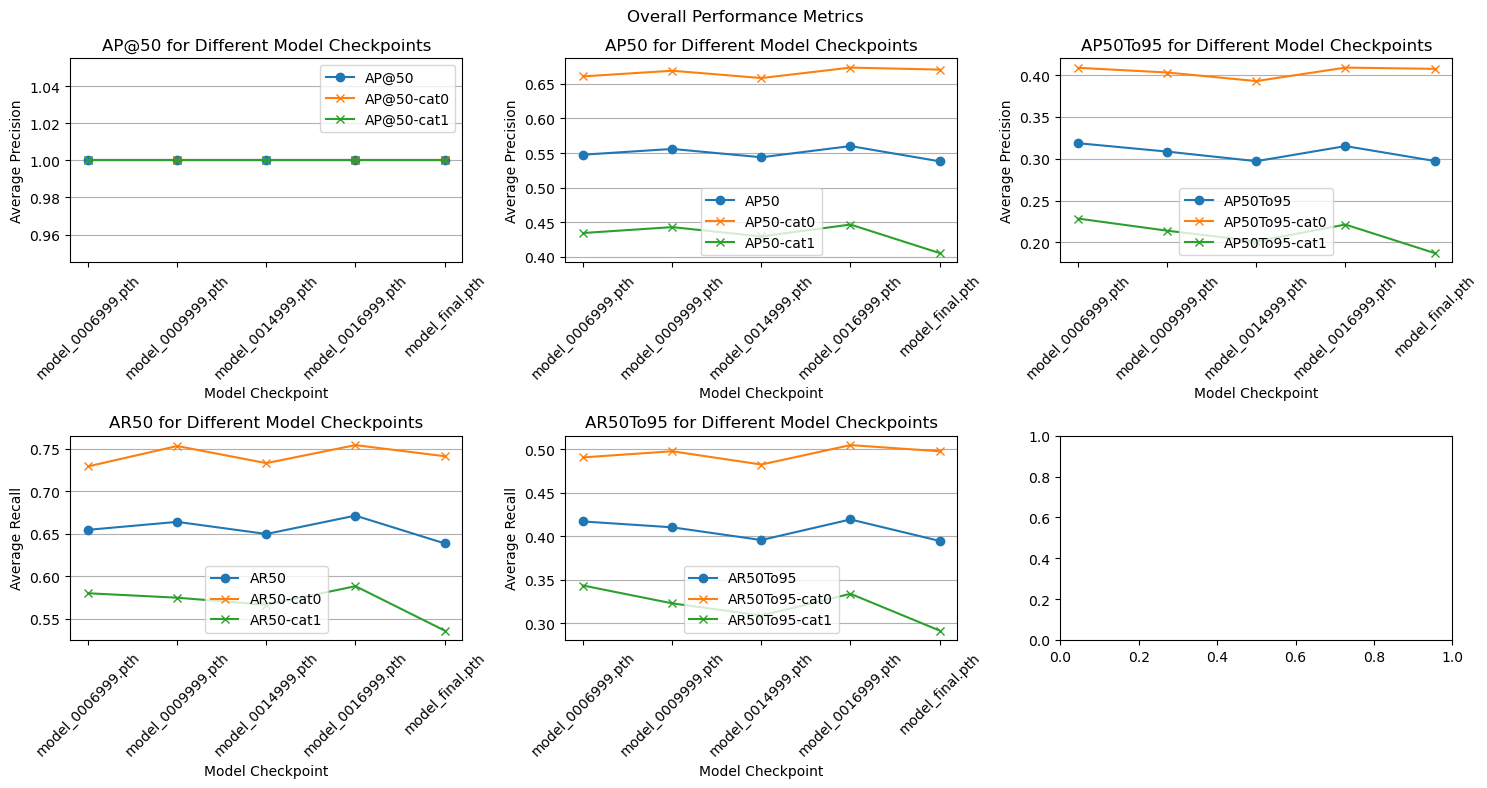

model_final          model_0006999.pth  model_0009999.pth  model_0014999.pth  \
AP@50                         1.000000           1.000000           1.000000   
AP@50Area-Small               1.000000           1.000000           1.000000   
AP@50Area-Medium              1.000000           1.000000           1.000000   
AP@50Area-Large               0.525000           0.555556           0.525000   
AP@50-cat0                    1.000000           1.000000           1.000000   
AP@50-cat1                    1.000000           1.000000           1.000000   
AP50                          0.547641           0.555961           0.543929   
AP50Area-Small                0.377476           0.415513           0.378844   
AP50Area-Medium               0.422442           0.439823           0.429220   
AP50Area-Large                0.422854           0.423608           0.413337   
AP50-cat0                     0.660839           0.669001           0.658416   
AP50-cat1                     0.434443  

In [4]:
dataset_name = "Phase3_Validation"
bbox_or_segm = "segm"
eval_model_on_dataset_name(dataset_name, bbox_or_segm)

Phase3 Testing

[04/08 16:03:45 d2.data.datasets.coco]: Loaded 13 images in COCO format from ./datasets/Phase3_Testing/Phase3_Testing.json
len(model_files): 5
model files:
 ['output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0009999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0014999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0016999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_final.pth'] 

--------------------------------------------------
Evaluating with MODEL.WEIGHTS = output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth
--------------------------------------------------

FPN -> in_features: ['stage3', 'stage4', 'stage5']
FPN -> strides: [8, 16, 32]
FPN -> top_block: LastLevelP6P7(
  (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
[04/08 16:03:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_l

/opt/anaconda3/envs/venv_mamba/envs/venv_py37_D2_6a/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


FPN level 0: 233 (33.1%); 	
FPN level 1: 470 (66.9%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 587 (44.6%); 	
FPN level 1: 730 (55.4%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 158 (35.3%); 	
FPN level 1: 289 (64.7%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 737 (47.6%); 	
FPN level 1: 812 (52.4%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 391 (46.1%); 	
FPN level 1: 457 (53.9%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 648 (46.5%); 	
FPN level 1: 746 (53.5%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0

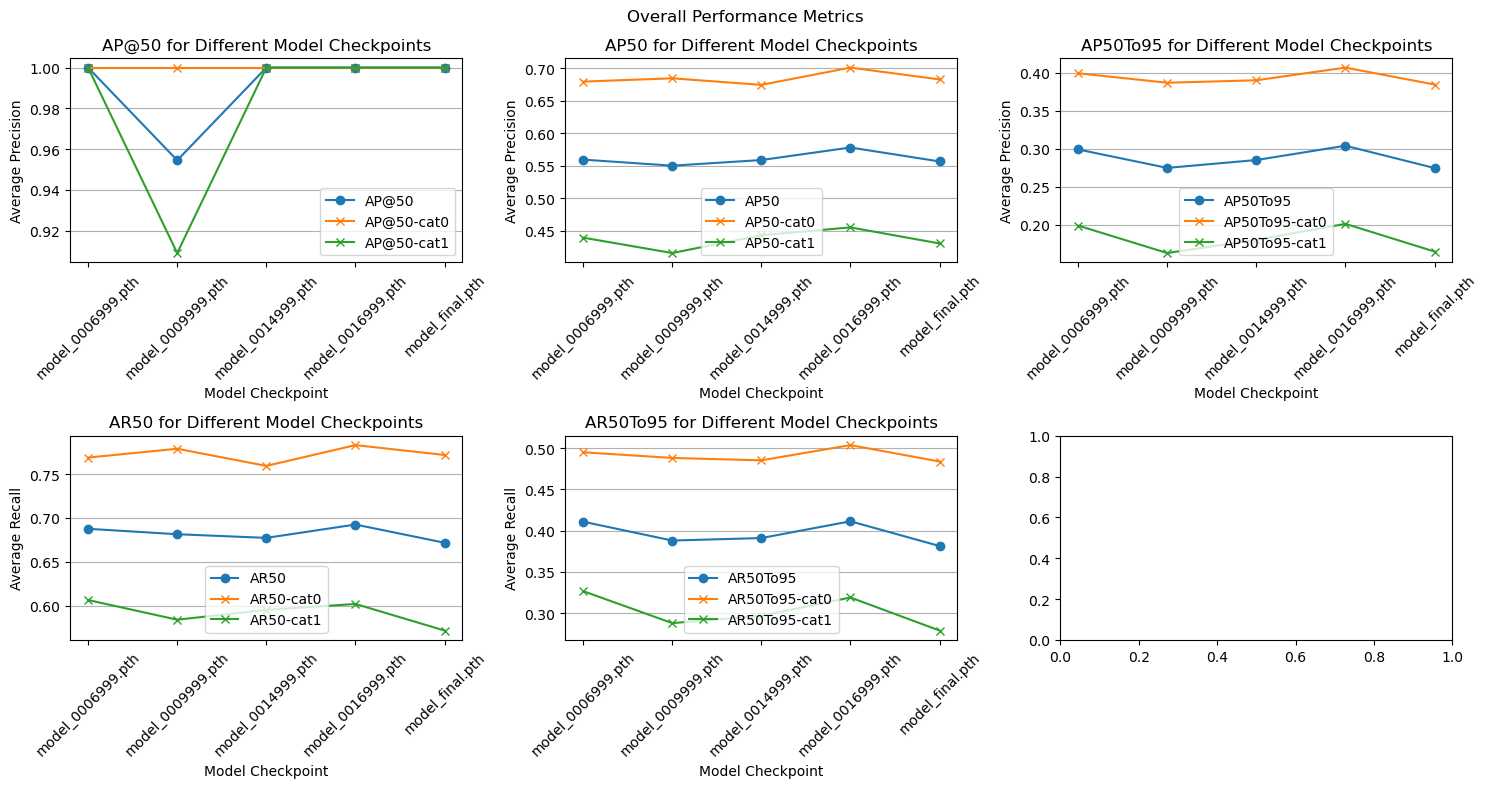

model_final          model_0006999.pth  model_0009999.pth  model_0014999.pth  \
AP@50                         1.000000           0.954545           1.000000   
AP@50Area-Small               1.000000           1.000000           1.000000   
AP@50Area-Medium              1.000000           0.875000           1.000000   
AP@50Area-Large               0.750000           0.500000           0.500000   
AP@50-cat0                    1.000000           1.000000           1.000000   
AP@50-cat1                    1.000000           0.909091           1.000000   
AP50                          0.559618           0.550292           0.558977   
AP50Area-Small                0.407780           0.439703           0.442877   
AP50Area-Medium               0.428774           0.426131           0.431861   
AP50Area-Large                0.445837           0.415486           0.406106   
AP50-cat0                     0.679806           0.684888           0.674779   
AP50-cat1                     0.439430  

In [5]:
dataset_name = "Phase3_Testing"
bbox_or_segm = "segm"
eval_model_on_dataset_name(dataset_name, bbox_or_segm)

Quigley / JHU Testing

[04/08 16:07:37 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./datasets/Quigley_Eval/Quigley_Eval.json
len(model_files): 5
model files:
 ['output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0009999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0014999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_0016999.pth', 'output/AxonClass/AxonClass-V-39-ms-3x/model_final.pth'] 

--------------------------------------------------
Evaluating with MODEL.WEIGHTS = output/AxonClass/AxonClass-V-39-ms-3x/model_0006999.pth
--------------------------------------------------

FPN -> in_features: ['stage3', 'stage4', 'stage5']
FPN -> strides: [8, 16, 32]
FPN -> top_block: LastLevelP6P7(
  (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
[04/08 16:07:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_later

/opt/anaconda3/envs/venv_mamba/envs/venv_py37_D2_6a/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


FPN level 0: 561 (37.7%); 	
FPN level 1: 929 (62.3%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 767 (44.4%); 	
FPN level 1: 961 (55.6%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 604 (39.0%); 	
FPN level 1: 945 (61.0%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 584 (38.3%); 	
FPN level 1: 940 (61.7%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 575 (37.4%); 	
FPN level 1: 961 (62.6%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0 (0.0%); 	
FPN level 4: 0 (0.0%); 	
GeneralizedRCNN.inference()->do_postprocess: True
FPN level 0: 689 (41.5%); 	
FPN level 1: 972 (58.5%); 	
FPN level 2: 0 (0.0%); 	
FPN level 3: 0

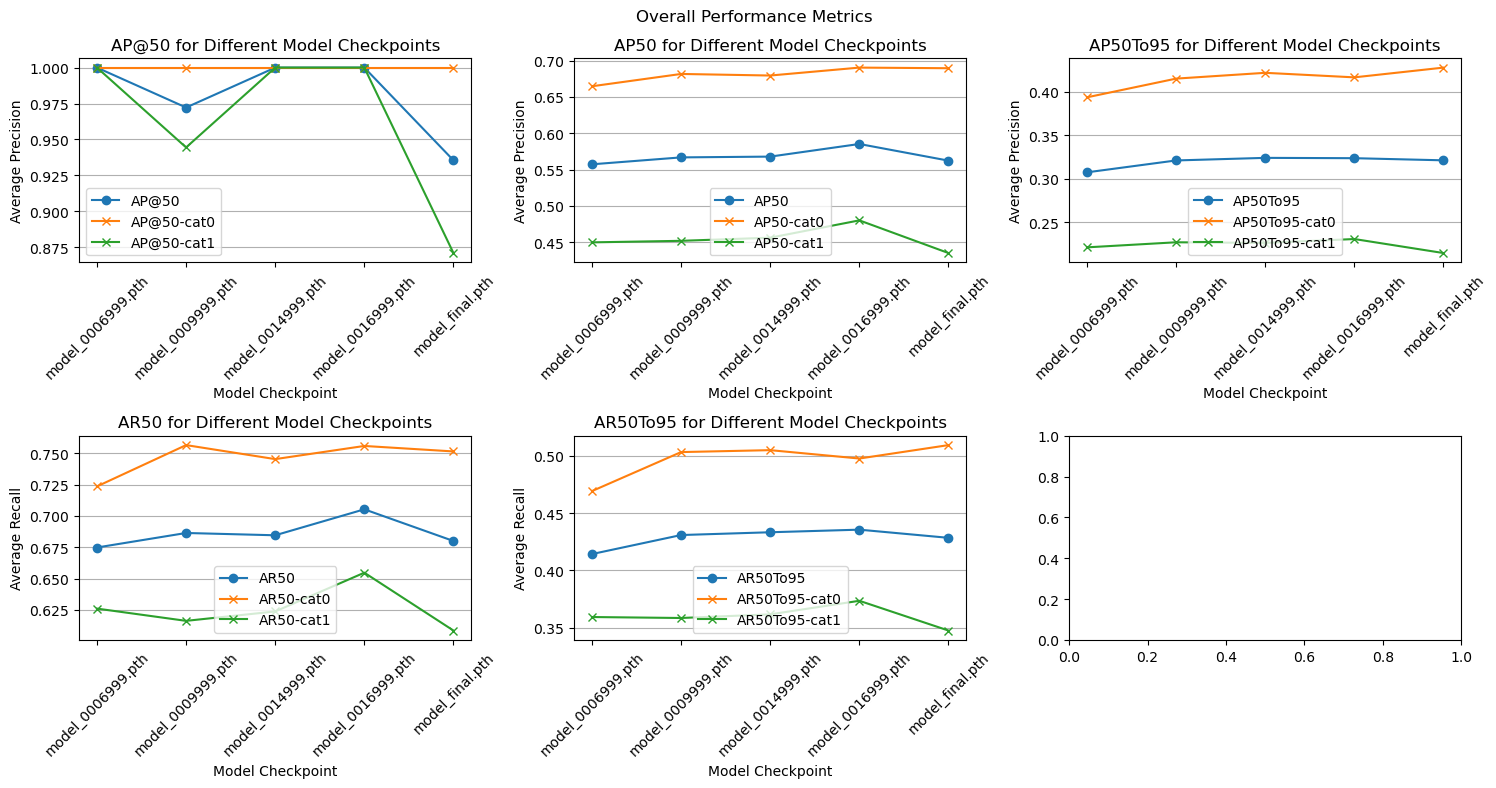

model_final          model_0006999.pth  model_0009999.pth  model_0014999.pth  \
AP@50                         1.000000           0.972222           1.000000   
AP@50Area-Small               1.000000           1.000000           0.853659   
AP@50Area-Medium              1.000000           1.000000           1.000000   
AP@50Area-Large               1.000000           0.833333           0.666667   
AP@50-cat0                    1.000000           1.000000           1.000000   
AP@50-cat1                    1.000000           0.944444           1.000000   
AP50                          0.557257           0.566790           0.567859   
AP50Area-Small                0.345146           0.370454           0.329153   
AP50Area-Medium               0.447508           0.508744           0.488127   
AP50Area-Large                0.459599           0.437811           0.441496   
AP50-cat0                     0.664790           0.681746           0.679578   
AP50-cat1                     0.449724  

In [6]:
dataset_name = "Quigley_Eval"
bbox_or_segm = "segm"
eval_model_on_dataset_name(dataset_name, bbox_or_segm)